In [605]:
from tqdm.notebook import tqdm
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as op3 
import pandas as pd
import time
from scipy.sparse.csgraph import connected_components
from open3d import JVisualizer
from BfTableGenerator import RansacCollector
from matplotlib import cm
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view
from DDBSCAN import Raster_DBSCAN
from scipy import ndimage 
import cv2
from scipy.optimize import linear_sum_assignment

theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]
theta = np.sort(theta_raw)
azimuths = np.arange(0,360,0.2)

In [896]:
class detected_object():
    def __init__(self):
        self.global_id = None
        self.represented_label_at_each_frame = None
        self.cur_motion = None
        self.occlusion_indicator = None
        self.start_frame = None
def get_tracking_points(Label_map,sparse_template):
    """
    Get sparsed tracking points as input implement the KL algorithm 
    
    
    """
    Label_map_sparesed = Label_map.copy()
    Label_map_sparesed[sparse_template] = 0
    tracking_points = np.array(np.where(Label_map_sparesed != 0)).T.reshape((-1,1,2))  
    represented_labels = Label_map_sparesed[tracking_points[:,:,0],tracking_points[:,:,1]]
    tracking_points = tracking_points.astype(np.float32)
    tracking_points = tracking_points[:,:,[1,0]]
    
    return tracking_points,represented_labels

def read_Td_map(ind,Label_map,width_fringe):
    
    Td_map_cur = Td_maps[ind].copy()
#     Td_map_cur[Label_map == 0] = 200
    Td_map_cur = (255*Td_map_cur/300).astype(np.uint8)
    Td_map_cur_padded = np.concatenate([Td_map_cur[:,-width_fringe:],
                                                    Td_map_cur,
                                                    Td_map_cur[:,:width_fringe]],axis = 1)
    return Td_map_cur,Td_map_cur_padded
def read_Label_map(ind,width_fringe):
    """
    Read Frame, the labels are started from 1, 0 refers to noise
    Lavel_map_cur or next size is padded to 32 x (1800 + 2 x int(win_size))
    Considering the roll over margin
    """
    Label_map_cur = Labeling_maps[ind].copy()
    Label_map_cur += 1
    Label_map_cur_padded = np.concatenate([Label_map_cur[:,-width_fringe:],
                                                Label_map_cur,
                                                Label_map_cur[:,:width_fringe]],axis = 1)
    return Label_map_cur,Label_map_cur_padded
def get_associations(Label_map_next_padded,valid_represented_labels,valid_tracking_points_pred):
    
    associations = np.concatenate(
    [valid_represented_labels.reshape((-1,1)), 
     #valid representative labels at current frame (transmitted to the pred position)
    Label_map_next_padded[valid_tracking_points_pred[:,1].astype(np.int16),valid_tracking_points_pred[:,0].astype(np.int16)].reshape((-1,1))] 
    # overlapped labels at next frame given the transmission
    ,axis = 1)

    #occured associations at next frame, overlapped points counts 
    occured_associations,associations_counts = np.unique(associations,axis = 0,return_counts=True)
    #exclude associations with background at next frame 
    occured_associations,associations_counts = occured_associations[occured_associations[:,1] != 0],associations_counts[occured_associations[:,1] != 0]

    #unique_valid_labels refers to labels in current frame which are overlapped at next frame 
    unique_valid_labels,valid_labels_counts  = np.unique(valid_represented_labels,return_counts=True)
    
    return occured_associations,associations_counts,unique_valid_labels,valid_labels_counts

In [2]:
os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest')
frame_set = np.arange(0,5000,1).astype('int')
collector = RansacCollector(pcap_path=r'./2020-7-27-10-30-0.pcap',frames_set = frame_set)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1,inuse_frame = frame_set)
# d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1 FrameSampling


  0%|          | 2/5000 [00:00<04:30, 18.48it/s]

Loading pcap...


  0%|          | 0/32 [00:00<?, ?it/s]

Generating Threshold Map


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


In [407]:
Thred_map = collector.thred_map
db = Raster_DBSCAN(window_size=(9,9),eps = 1.5, min_samples= 20,Td_map_szie=Thred_map.shape)

In [408]:
Td_maps = []
Labeling_maps = []
Time_consumings = []
for i in tqdm(range(2000)):
    ti = time.time()
    Td_map = collector.td_maps[i].copy()
    Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Td_maps.append(Td_map)
    Labeling_maps.append(Labeling_map)
    Time_consumings.append((time.time() - ti)*1000)

In [610]:
"""
Initial params
"""
window_size_lk = 11
width_fringe = int(window_size_lk/2)
sparse_interval = 1800 # this param controls the sparese degree of LK implementation, smaller it is, the Label matrix is sparser
sparse_ind = np.array(np.meshgrid(np.arange(Thred_map.shape[0]),np.arange(0,Thred_map.shape[1] + 2 * width_fringe,sparse_interval))).T.reshape(-1,2)
sparse_template = np.full((Thred_map.shape[0],Thred_map.shape[1] + 2 * width_fringe),False)
# sparse_template[sparse_ind[:,0],sparse_ind[:,1]] = True
lk_params = dict(winSize = (window_size_lk,window_size_lk),
                maxLevel = 2,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,1,0.01))
cur_frame = 0 #current frame number
global_id = 0
tracking_list = {}
off_tracked_list = {}

In [611]:
"""
Initialization Code
"""
Label_map_initial,Label_map_initial_padded = read_Label_map(cur_frame,width_fringe)
Td_map_initial,Td_map_initial_padded = read_Td_map(cur_frame,Label_map_initial,width_fringe)

# Generate prerequisites Label maps(padded), Td maps(padded)
Label_map_cur,Label_map_cur_padded = Label_map_initial,Label_map_initial_padded
Td_map_cur,Td_map_cur_padded = Td_map_initial,Td_map_initial_padded

tracking_points_cur,represented_labels_cur = get_tracking_points(Label_map_cur_padded,sparse_template)
cur_total_labels = np.unique(represented_labels_cur)

for l in cur_total_labels:
    temp_obj = detected_object()
    temp_obj.represented_label_at_each_frame = [l]
    temp_obj.global_id = global_id
    temp_obj.start_frame = cur_frame
    if global_id not in tracking_list.keys():
        tracking_list[global_id] = temp_obj
        global_id += 1


In [612]:
while cur_frame<1100:
    
    cur_frame += 1
    Label_map_next,Label_map_next_padded = read_Label_map(cur_frame,width_fringe)
    Td_map_next,Td_map_next_padded = read_Td_map(cur_frame,Label_map_next,width_fringe)
    #represented_labels is the labels that tracking points representing at current frame 
    tracking_points_next,represented_labels_next = get_tracking_points(Label_map_next_padded,sparse_template)
#     tracking_points_cur,represented_labels_cur = get_tracking_points(Label_map_cur_padded,sparse_template)
    """
    Using the tracking points to calculate the optical flow, 
    the result represent the entire motion pattern of each cluster 
    also, the Td_maps need to be padded in order to issue the roll over problem
    the motion estimated result is given in valid_tracking_points_pred,
    st is an indicator indicating  which tracking point is successfully tracked 

    """
    tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points_cur,
                                                           None,**lk_params)
    valid_tracking_points_pred = tracking_points_pred[st == 1]
    condition1 = (valid_tracking_points_pred[:,0] < Td_map_cur_padded.shape[1] - 1)&(valid_tracking_points_pred[:,0] > 0)
    condition2 = (valid_tracking_points_pred[:,1] < Td_map_cur_padded.shape[0] - 1)&(valid_tracking_points_pred[:,1] > 0)
    valid_tracking_points_pred = valid_tracking_points_pred[condition1 & condition2]

    
    # the labels representing each predicted point 
    valid_represented_labels = represented_labels_cur[st == 1]
    valid_represented_labels = valid_represented_labels[condition1 & condition2]
    occured_associations,associations_counts,unique_valid_labels,valid_labels_counts = get_associations(Label_map_next_padded,
                                                                                                        valid_represented_labels,
                                                                                                      valid_tracking_points_pred)
    
    #Hungarium 
    
    labels_cur,labels_next = np.array([tracking_list[key].represented_label_at_each_frame[-1] for key in tracking_list.keys()]),np.unique(represented_labels_next)
    glob_id_cur = np.array([key for key in tracking_list.keys()])
    inter_association_overlappe_mat = np.zeros((len(labels_cur),len(labels_next)))
    for i,pair in enumerate(occured_associations):
        inter_association_overlappe_mat[pair[0] == labels_cur,pair[1] == labels_next] = associations_counts[i]
    cur_labels_ind,next_labels_ind = linear_sum_assignment(-inter_association_overlappe_mat)
    
    # in a but not in b
    failed_tracked_ind = np.setdiff1d(np.arange(len(labels_cur)),cur_labels_ind) # in the relative position who failed to tracking 
    if len(failed_tracked_ind) > 0:
        failed_glb_id = glob_id_cur[failed_tracked_ind]
        for fid in failed_glb_id:
            off_tracked_list[fid] = tracking_list.pop(fid)

    new_detection_ind = np.setdiff1d(np.arange(len(labels_next)),next_labels_ind)
    for i,ind in enumerate(new_detection_ind):
        temp_obj = detected_object()
        temp_obj.global_id = global_id
        temp_obj.start_frame = cur_frame
        global_id += 1
        temp_obj.represented_label_at_each_frame = [labels_next[ind]]
        tracking_list[global_id] = temp_obj
        
        
    for i,label_ind in enumerate(cur_labels_ind):
        tracking_list[glob_id_cur[label_ind]].represented_label_at_each_frame.append(labels_next[next_labels_ind[i]])
    
    Label_map_cur,Label_map_cur_padded = Label_map_next,Label_map_next_padded
    Td_map_cur,Td_map_cur_padded = Td_map_next,Td_map_next_padded
    tracking_points_cur,represented_labels_cur = tracking_points_next,represented_labels_next
    
keys = [key for key in tracking_list.keys()]
for key in keys:
    off_tracked_list[key] = tracking_list.pop(key)
    

In [613]:
np.random.seed(150)
color_map = np.random.random((100,3))
color_map = np.concatenate([color_map,np.array([[1,1,1]])])

for f in range(1000):
    Td_map = Td_maps[f]
    Labeling_map = Labeling_maps[f].copy()
    Labeling_map += 1
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = np.zeros((len(Labels),3))
    for key in off_tracked_list:
        n = f - off_tracked_list[key].start_frame
        if (n >= 0) & (n < len(off_tracked_list[key].represented_label_at_each_frame)):
            label_cur_frame = off_tracked_list[key].represented_label_at_each_frame[n]
            Colors[Labels == label_cur_frame] = color_map[key%len(color_map)]
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    op3.io.write_point_cloud(r'./Output File/PcdSequence'+"/{}.pcd".format(f), pcd)
        
            

In [396]:
def visualize(Td_map,Labeling_map):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])


    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = []
    for i in range(len(Labels)):
        Colors.append(color_map[Labels[i]])
    Colors = np.array(Colors)
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    visualizer = JVisualizer()
    visualizer.add_geometry(pcd)
    visualizer.show()

In [426]:
f = 4
Td_map = collector.td_maps[f].copy()
db = Raster_DBSCAN(window_size=(9,9),eps = 1.5, min_samples= 20,Td_map_szie=Thred_map.shape)
Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
visualize(Td_map,Labeling_map)

JVisualizer with 1 geometries

In [965]:
Obstacle_map = (Td_map_initial>Thred_map)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [962]:
window_size_lk = 21
lk_params = dict(winSize = (window_size_lk,5),
                maxLevel = 3,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,100,0.1))
width_fringe = int(window_size_lk/2)

sparse_interval = 1800 # this param controls the sparese degree of LK implementation, smaller it is, the Label matrix is sparser
sparse_ind = np.array(np.meshgrid(np.arange(Thred_map.shape[0]),np.arange(0,Thred_map.shape[1] + 2 * width_fringe,sparse_interval))).T.reshape(-1,2)
sparse_template = np.full((Thred_map.shape[0],Thred_map.shape[1] + 2 * width_fringe),False)

cur_frame = 2
Td_map_initial,Label_map_initial_padded = read_Label_map(cur_frame,width_fringe)
Td_map_initial,Td_map_initial_padded = read_Td_map(cur_frame,Label_map_initial,width_fringe)
cur_frame = 3
Label_map_cur,Label_map_cur_padded = read_Label_map(cur_frame,width_fringe)
Td_map_cur,Td_map_cur_padded = read_Td_map(cur_frame,Label_map_cur,width_fringe)
cur_frame = 4
Label_map_next,Label_map_next_padded = read_Label_map(cur_frame,width_fringe)
Td_map_next,Td_map_next_padded = read_Td_map(cur_frame,Label_map_next,width_fringe)

In [959]:
tracking_points_initial,represented_labels_initial = get_tracking_points(Label_map_initial_padded,sparse_template)
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_initial_padded,Td_map_cur_padded,tracking_points_initial,
                                                           None,**lk_params)
valid_tracking_points_pred = tracking_points_pred[st == 1]
valid_represented_labels = represented_labels_initial[st == 1]
condition1 = (valid_tracking_points_pred[:,0] < Td_map_cur_padded.shape[1] - 1)&(valid_tracking_points_pred[:,0] > 0)
condition2 = (valid_tracking_points_pred[:,1] < Td_map_cur_padded.shape[0] - 1)&(valid_tracking_points_pred[:,1] > 0)
valid_represented_labels = valid_represented_labels[condition1 & condition2]
valid_tracking_points_pred = valid_tracking_points_pred[condition1 & condition2]

valid_tracking_points_pred_initial2cur = valid_tracking_points_pred.copy()
valid_represented_labels_initial2cur = valid_represented_labels.copy()


In [960]:
tracking_points_cur,represented_labels_cur = valid_tracking_points_pred.reshape((-1,1,2)),valid_represented_labels.reshape((-1,1))
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points_cur,
                                                           None,**lk_params)
valid_tracking_points_pred = tracking_points_pred[st == 1]
valid_represented_labels = represented_labels_cur[st == 1]

condition1 = (valid_tracking_points_pred[:,0] < Td_map_cur_padded.shape[1] - 1)&(valid_tracking_points_pred[:,0] > 0)
condition2 = (valid_tracking_points_pred[:,1] < Td_map_cur_padded.shape[0] - 1)&(valid_tracking_points_pred[:,1] > 0)
valid_represented_labels = valid_represented_labels[condition1 & condition2]
valid_tracking_points_pred = valid_tracking_points_pred[condition1 & condition2]

valid_tracking_points_pred_cur2next = valid_tracking_points_pred.copy()
valid_represented_labels_cur2next = valid_represented_labels.copy()


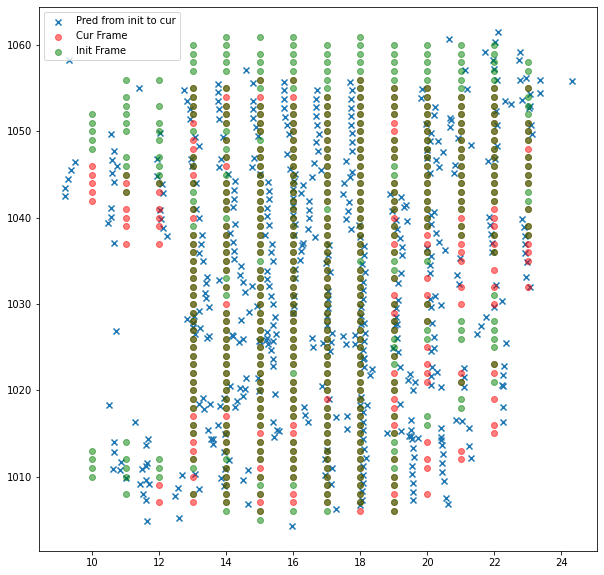

In [961]:
plt.figure(figsize = (10,10))
plt.scatter(valid_tracking_points_pred_initial2cur[:,1][valid_represented_labels_initial2cur == 1],valid_tracking_points_pred_initial2cur[:,0][valid_represented_labels_initial2cur == 1]
            ,marker = 'x',label = 'Pred from init to cur')
rows,cols = np.where(Label_map_cur_padded == 1)
plt.scatter(rows,cols,label = 'Cur Frame',alpha = 0.5,c = 'r')
rows,cols = np.where(Label_map_initial_padded == 1)
plt.scatter(rows,cols,label = 'Init Frame',alpha = 0.5,c = 'g')
plt.legend()
plt.show()

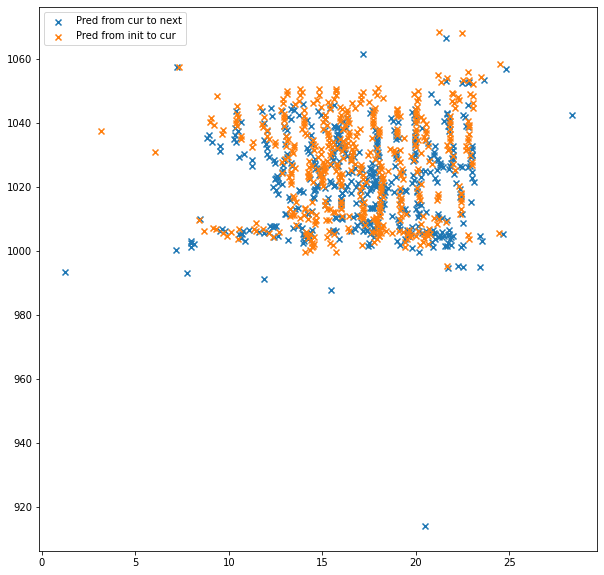

In [953]:
plt.figure(figsize = (10,10))
plt.scatter(valid_tracking_points_pred_cur2next[:,1][valid_represented_labels_cur2next == 1],valid_tracking_points_pred_cur2next[:,0][valid_represented_labels_cur2next == 1]
            ,marker = 'x',label = 'Pred from cur to next')
plt.scatter(valid_tracking_points_pred_initial2cur[:,1][valid_represented_labels_initial2cur == 1],valid_tracking_points_pred_initial2cur[:,0][valid_represented_labels_initial2cur == 1]
            ,marker = 'x',label = 'Pred from init to cur')
plt.legend()
plt.show()

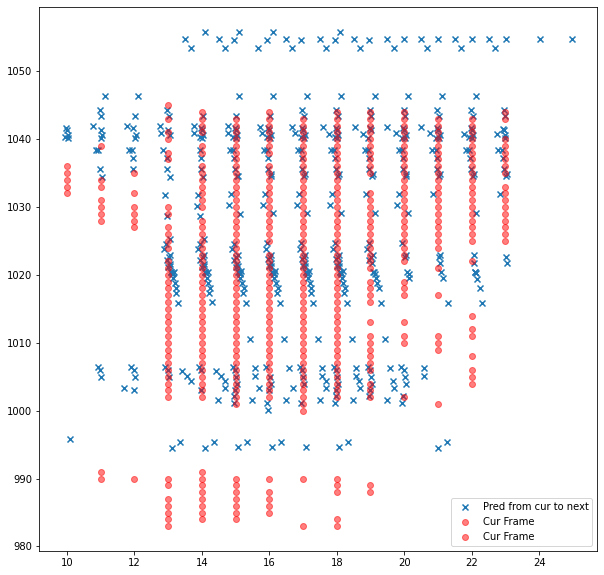

In [922]:
plt.figure(figsize = (10,10))
plt.scatter(valid_tracking_points_pred_cur2next[:,1][valid_represented_labels_cur2next == 1],valid_tracking_points_pred_cur2next[:,0][valid_represented_labels_cur2next == 1]
            ,marker = 'x',label = 'Pred from cur to next')
rows,cols = np.where(Label_map_next_padded == 1)
plt.scatter(rows,cols,label = 'Cur Frame',alpha = 0.5,c = 'r')
rows,cols = np.where(Label_map_next_padded == 3)
plt.scatter(rows,cols,label = 'Cur Frame',alpha = 0.5,c = 'r')
plt.legend()
plt.show()

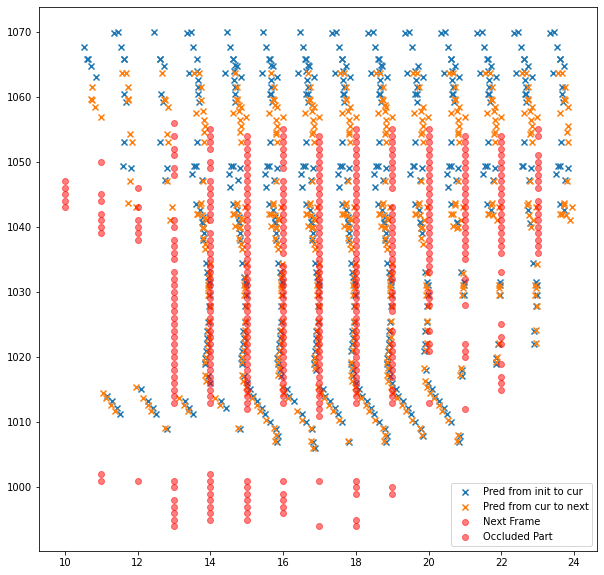

In [732]:
plt.figure(figsize = (10,10))
plt.scatter(valid_tracking_points_pred_initial2cur[:,1][valid_represented_labels_initial2cur == 1],valid_tracking_points_pred_initial2cur[:,0][valid_represented_labels_initial2cur == 1]
            ,marker = 'x',label = 'Pred from init to cur')
plt.scatter(valid_tracking_points_pred_cur2next[:,1][valid_represented_labels_cur2next == 1],valid_tracking_points_pred_cur2next[:,0][valid_represented_labels_cur2next == 1]
            ,marker = 'x',label = 'Pred from cur to next')
rows,cols = np.where(Label_map_next_padded == 1)
plt.scatter(rows,cols,label = 'Next Frame',alpha = 0.5,c = 'r')
rows,cols = np.where(Label_map_next_padded == 3)
plt.scatter(rows,cols,label = 'Occluded Part',alpha = 0.5,c = 'r')
plt.legend()
plt.show()

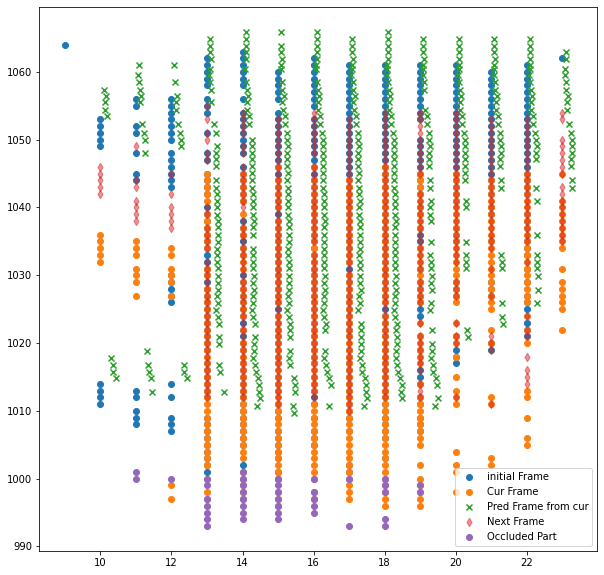

In [647]:


## init - cur 
tracking_points_initial,represented_labels_initial = get_tracking_points(Label_map_initial_padded,sparse_template)
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_initial_padded,Td_map_cur_padded,tracking_points_initial,
                                                           None,**lk_params)
valid_tracking_points_pred = tracking_points_pred[st == 1]
valid_represented_labels = represented_labels_initial[st == 1]
condition1 = (valid_tracking_points_pred[:,0] < Td_map_cur_padded.shape[1] - 1)&(valid_tracking_points_pred[:,0] > 0)
condition2 = (valid_tracking_points_pred[:,1] < Td_map_cur_padded.shape[0] - 1)&(valid_tracking_points_pred[:,1] > 0)
valid_represented_labels = valid_represented_labels[condition1 & condition2]
valid_tracking_points_pred = valid_tracking_points_pred[condition1 & condition2]


## cur - next
tracking_points_cur,represented_labels_cur = valid_tracking_points_pred.reshape((-1,1,2)),valid_represented_labels
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points_cur,
                                                           None,**lk_params)

In [ ]:
plt.figure(figsize = (10,10))
rows,cols = np.where(Label_map_initial == 1)
plt.scatter(rows,cols,label = 'initial Frame',marker = 'o')
rows,cols = np.where(Label_map_cur == 1)
plt.scatter(rows,cols,label = 'Cur Frame',marker = 'o')
plt.scatter(valid_tracking_points_pred[:,1][valid_represented_labels == 1],valid_tracking_points_pred[:,0][valid_represented_labels == 1],marker = 'x',label = 'Pred Frame from cur')
rows,cols = np.where(Label_map_next_padded == 1)
plt.scatter(rows,cols,label = 'Next Frame',marker = 'd',alpha = 0.5)
rows,cols = np.where(Label_map_next_padded == 3)
plt.scatter(rows,cols,label = 'Occluded Part')
plt.legend()

In [ ]:
# frame: 4 labels = [1,3]
# frame: 3 labels = [1]
# frame: 2 labels = [1]

In [ ]:
tracking_points_cur,represented_labels_cur = get_tracking_points(Label_map_cur_padded,sparse_template)
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points_cur,
                                                           None,**lk_params)
valid_tracking_points_pred = tracking_points_pred[st == 1]
valid_represented_labels = represented_labels_cur[st == 1]
condition1 = (valid_tracking_points_pred[:,0] < Td_map_cur_padded.shape[1] - 1)&(valid_tracking_points_pred[:,0] > 0)
condition2 = (valid_tracking_points_pred[:,1] < Td_map_cur_padded.shape[0] - 1)&(valid_tracking_points_pred[:,1] > 0)
valid_represented_labels = valid_represented_labels[condition1 & condition2]
valid_tracking_points_pred = valid_tracking_points_pred[condition1 & condition2]

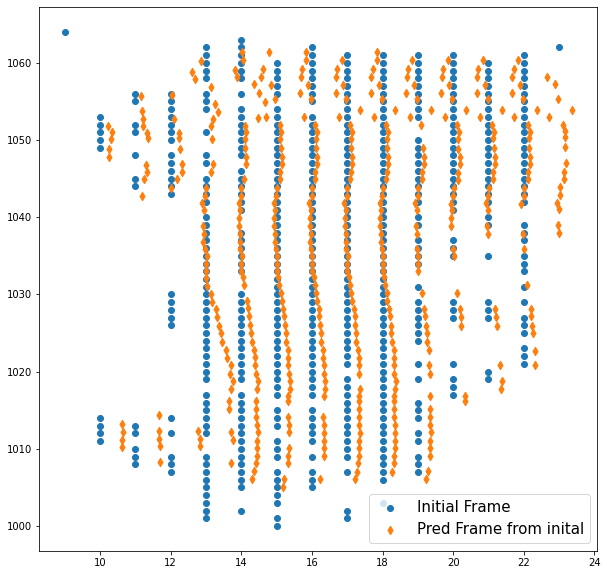

In [631]:
plt.figure(figsize = (10,10))
rows,cols = np.where(Label_map_initial == 1)
plt.scatter(rows,cols,label = 'Initial Frame')
plt.scatter(valid_tracking_points_pred[:,1][valid_represented_labels == 1],valid_tracking_points_pred[:,0][valid_represented_labels == 1],marker = 'd',label = 'Pred Frame from inital')
# rows,cols = np.where(Label_map_next_padded == 1)
# plt.scatter(rows,cols,marker = 'x',label = 'Next Frame')
# rows,cols = np.where(Label_map_next_padded == 3)
# plt.scatter(rows,cols,label = 'Occluded Part')
plt.legend(fontsize = 15)
plt.show()
# plt.scatter(valid_tracking_points_pred[:,1],valid_tracking_points_pred[:,0],marker = 'x')

In [440]:
def visualize_label(Td_map,Labeling_map,labels):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = []
    for i in range(len(Labels)):
        if Labels[i] in labels:
            Colors.append(color_map[0])
        else:
            Colors.append(color_map[-1])
    Colors = np.array(Colors)
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    visualizer = JVisualizer()

    visualizer.add_geometry(pcd)
    visualizer.show()

In [ ]:
# frame: 4 labels = [0,2]
# frame: 3 labels = [0]
# frame: 2 labesl = [0]

In [649]:
frame_ind = 4
labels = [0,2]
visualize_label(Td_maps[frame_ind],Labeling_maps[frame_ind],labels)

JVisualizer with 1 geometries

In [616]:
frame_ind = 2
labels = [0]
visualize_label(Td_maps[frame_ind],Labeling_maps[frame_ind],labels)

JVisualizer with 1 geometries